In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py as h5
import re
import pickle
from scipy.stats import linregress
from scipy.optimize import curve_fit
from operator import itemgetter
from collections import OrderedDict
sys.path.append('/home/vagrant/jupyter/repos/ioptics/ioptics/tools/') # added specifically for cchall@jupyter.radiasoft.org

import elliptic
import utils
# from rsbeams.rsptcls.phases import phase_advance, tune_fft

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
# mpl.style.use('/home/vagrant/jupyter/repos/rsbeams/rsbeams/matplotlib/stylelib/rs_paper.mplstyle')
# mpl.rcParams['figure.dpi'] = 100

# Plot Styling

# import seaborn
# seaborn.set_style("white")
# seaborn.set_context('notebook')
from cycler import cycler

colors = ["xkcd:windows blue", "xkcd:amber", "xkcd:faded green", 
          "xkcd:dusty purple", "xkcd:blood orange", "xkcd:bluish grey", 
          "xkcd:carmine", "xkcd:greenish blue", "xkcd:wine",
          "xkcd:spruce"]

def subplots(x, y, **kwargs):
    array = np.ones([x, y])
    fig, array = plt.subplots(x, y, **kwargs)
    try:
        for plot in array.flat:
            plot.set_prop_cycle(cycler('color', colors))
    except AttributeError:
        array.set_prop_cycle(cycler('color', colors))
    
    return fig, array

In [2]:
1e-6 / 195.695119849

5.109989461012662e-09

In [3]:
from scipy.constants import e

In [4]:
1e9 * e / 133e-9

0.0012046440757894738

In [5]:
10.8e-2 / 3e8

3.6e-10

In [6]:
1 / 30e6

3.3333333333333334e-08

In [7]:

directory = './lattice84_waterbag_t0p4_c0p01_equil_hkick5864urad/'

coordinates = utils.get_all_turns(directory, 'particles', 10000, mod=1)
parameters = pickle.load( open( os.path.join(directory,'run_parameters.p'), "rb" ) )
invariants = utils.calculate_invariants(coordinates, 
                                        parameters['beta_0'],
                                        parameters['alpha_0'],
                                        parameters['t'],
                                        parameters['c'])

Last turn in directory:particles_2001.h5
Shape of last bunch array: (1459,7)


KeyError: 'beta_0'

In [9]:
turns = 2001
interval = 1
mod = 1

# Plots

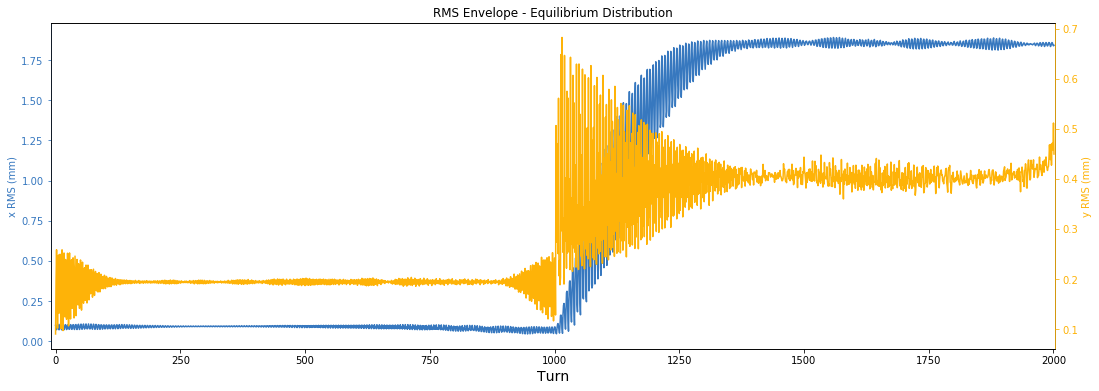

In [10]:
fig1 = plt.figure(figsize=(18,6))
cx = plt.gca()
cx.set_title("RMS Envelope - Equilibrium Distribution")

cx.plot(np.arange(turns +1 )[::interval * mod], 
        np.array([np.std(coordinates[i,:,0]) * 1e3 for i in range(turns // (interval * mod) + 1)]),
        label='x 10 mm-mrad', color=colors[0])

cx2 = cx.twinx()
cx2.plot(np.arange(turns +1 )[::interval * mod], 
        np.array([np.std(coordinates[i,:,2]) * 1e3 for i in range(turns // (interval * mod) + 1)]),
        label='y 10 mm-mrad', color=colors[1])

cx.set_xlim(-10,turns+2)
cx.set_xlabel("Turn",fontsize=14)
cx.set_ylabel( "x RMS (mm)", color=colors[0])
cx2.set_ylabel( "y RMS (mm)", color=colors[1])


cx.tick_params(axis='y',colors=colors[0])
cx.spines['left'].set_color(colors[0])
cx2.tick_params(axis='y',colors=colors[1])
cx2.spines['right'].set_color(colors[1])

# cx.legend(loc='best',title='')

# fig1.savefig('10um_envelope.pdf')
plt.show()

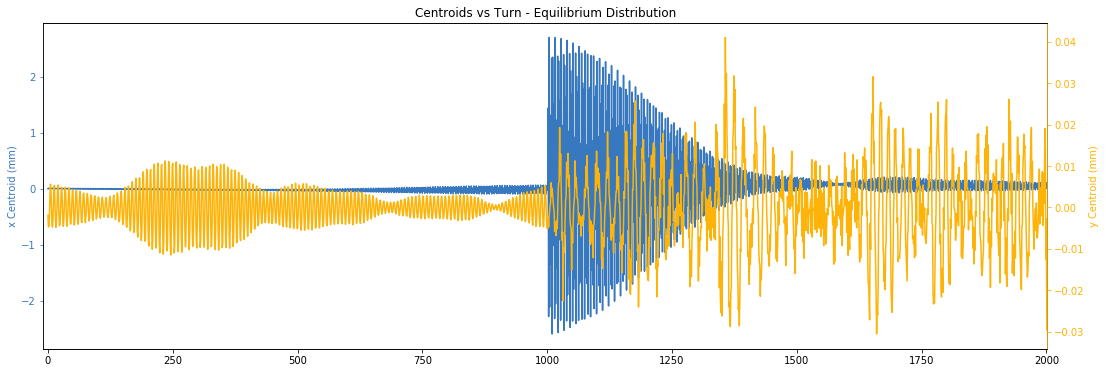

In [11]:
fig2 = plt.figure(figsize=(18,6))
cx = plt.gca()
cx.set_title("Centroids vs Turn - Equilibrium Distribution")

cx.plot(np.arange(turns + 1)[::interval * mod], 
        np.array([np.average(coordinates[i,:,0])*1e3 for i in range(turns // (interval * mod) + 1)]),
        label='x 10 mm-mrad', color=colors[0])

cx2 = cx.twinx()
cx2.plot(np.arange(turns + 1)[::interval * mod], 
        np.array([np.average(coordinates[i,:,2])*1e3 for i in range(turns // (interval * mod) + 1)]),
        label='y 10 mm-mrad', color=colors[1])

cx.set_xlim(-10,turns+1)
cx.set_ylabel( "x Centroid (mm)", color=colors[0])
cx2.set_ylabel( "y Centroid (mm)", color=colors[1])

cx.tick_params(axis='y',colors=colors[0])
cx.spines['left'].set_color(colors[0])
cx2.tick_params(axis='y',colors=colors[1])
cx2.spines['right'].set_color(colors[1])


# cx.legend(loc=1,title='')
# fig2.savefig("10um_centroids.pdf")
plt.show()

In [30]:
10e-6 / 195

5.1282051282051286e-08

# Distribution Animation

In [12]:
# From Webb implementation in rssynergia.elliptic.

def computepotential(xHat, yHat, t, c):
    """Compute the general potential"""
    quadratic = 0.5 * (xHat**2 + yHat**2)

    ellipticT = -1.* t
    ellipticC = c

    elliptic = 0.
    kfac = 1.
    if ellipticT != 0.:
        xN = xHat / ellipticC
        yN = yHat / ellipticC

        # Elliptic coordinates
        u = ( np.sqrt((xN + 1.)**2 + yN**2) +
              np.sqrt((xN - 1.)**2 + yN**2) )/2.
        v = ( np.sqrt((xN + 1.)**2 + yN**2) -
              np.sqrt((xN - 1.)**2 + yN**2) )/2.

        f2u = u * np.sqrt(u**2 - 1.) * np.arccosh(u)
        g2v = v * np.sqrt(1. - v**2) * (-np.pi/2 + np.arccos(v))

        kfac = ellipticT * ellipticC**2
        elliptic = (f2u + g2v) / (u**2 - v**2)

    potential = quadratic + kfac * elliptic
    return potential

def elliptic_coord(xHat,yHat,beta,t,c):
    xhat = xHat*1.0/c
    yhat = yHat*1.0/c

    u = 0.5*(np.sqrt((xhat + 1.)**2 + yhat**2) + np.sqrt((xhat -1.)**2 + yhat**2))
    v = 0.5*(np.sqrt((xhat + 1.)**2 + yhat**2) - np.sqrt((xhat -1.)**2 + yhat**2))

    return [u,v]


def calc_second_invariant(xHat, yHat, t, c):
    # Not the complete Invariant!!!
    # Only calculates the coordinate dependence portion
    
    t = -1.0*t
    c = 1.0*c
    
    xN = xHat / c
    yN = yHat / c

    u = ( np.sqrt((xN + 1.)**2 + yN**2) +
          np.sqrt((xN - 1.)**2 + yN**2) )/2.
    v = ( np.sqrt((xN + 1.)**2 + yN**2) -
          np.sqrt((xN - 1.)**2 + yN**2) )/2.

    # harmonic part of potential
    f1u = c**2 * u**2 * (u**2 -1.)
    g1v = c**2 * v**2 * (1.-v**2)

    # elliptic part of potential
    f2u = -t * c**2 * u * np.sqrt(u**2-1.) * np.arccosh(u)
    g2v = -t * c**2 * v * np.sqrt(1.-v**2) * (0.5*np.pi - np.arccos(v))

    # combined - Adjusted this from Stephen's code
    fu = (0.5 * f1u - f2u)
    gv = (0.5 * g1v + g2v)

    invariant = 2.*(c**2) * (fu * v**2 + gv * u**2)/(u**2 - v**2)

    return invariant

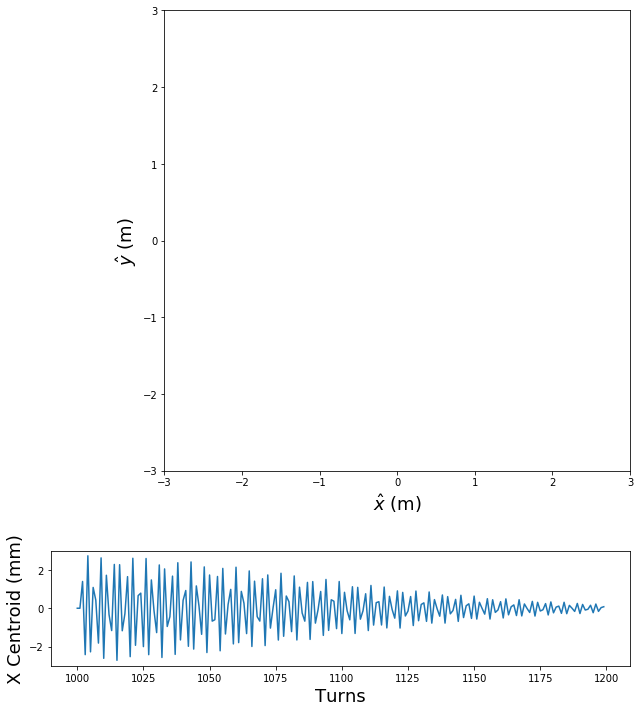

In [21]:
# Production video
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize=(9, 10))
gs = mpl.gridspec.GridSpec(2, 3, height_ratios=[4, 1], width_ratios=[1, 7.25, 1]) 
ax1=fig.add_subplot(gs[0, 1:3])
ax2=fig.add_subplot(gs[1, :])
ax3=fig.add_subplot(gs[0, 0])
ax3.axis('off')

turn_start = 1000
turn_stop = 1200

ymin = -1.0
ymax =  1.0

frames = []

ax1.set_xlabel("$\hat{x}$ (m)", fontsize=18)
ax1.set_ylabel("$\hat{y}$ (m)", fontsize=18)

ax2.set_xlabel("Turns", fontsize=18)
ax2.set_ylabel("X Centroid (mm)", fontsize=18)


ax2.plot(np.arange(turn_start, turn_stop, 1),np.array([np.average(coordinates[i,:,0]) * 1e3 for i in range(turn_start, turn_stop, 1)]),
        label=key)

for sc in np.arange(turn_start, turn_stop,1):
    pt = ax1.scatter(coordinates[sc,:,0] * 1e3, 
                     coordinates[sc,:,2] * 1e3,
                     c='#1f77b4',
                     s=2)
    
    pt_line, = ax2.plot([sc, sc], [ymin, ymax], c='#ff7f0e')
    frames.append([pt, pt_line,])

ctp2_artist = plt.Line2D((0,1),(0,0), color='g', linestyle='--',label='16 mm-mrad\n500 $\mu m$ offset')
ctp3_artist = plt.Line2D((0,1),(0,0), color='r', linestyle='--',label='20 mm-mrad\n No offset')

# ax3.legend(handles=[ctp2_artist, ctp3_artist], bbox_to_anchor=(0.05, 0.85), borderaxespad=0., fontsize=14)
# plt.setp(ax1.get_xticklabels(), fontsize=14)
# plt.setp(ax1.get_yticklabels(), fontsize=14)
# plt.setp(ax2.get_xticklabels(), fontsize=14)
# plt.setp(ax2.get_yticklabels(), fontsize=14)
# ax1.set_xticks(np.linspace(-0.01, 0.01, 5))
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

ax2.set_ylim(-3, 3)

plt.tight_layout()
im_ani = animation.ArtistAnimation(fig, frames, interval=250, repeat_delay=3000,
                                   blit=False)
# im_ani.save('test2.mp4', fps=8, dpi=300)
plt.show()

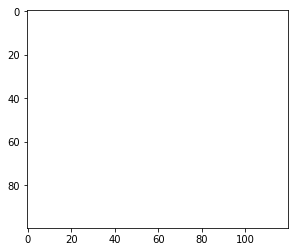

In [24]:
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()

## Decoherence Rates

In [9]:
import numpy as np
from pathos.multiprocessing import Pool, cpu_count
from scipy.integrate import quad
from scipy.special import fresnel


class CentroidPosition:
    """
    Calculate position of an initially offset beam centroid vs turn.
    Assumes a waterbag distribution and arbitrary order in tune dependence with amplitude.
    Based on SSC-N-360.
    """
    def __init__(self, N, Z, nu0, mu):
        """
        Set up to perform integrations of centroid positions. Centroid positions can be found after setup by calling
        the `calculate_centroid` method.

        Note that mu contains the coefficients for the tune amplitude dependence with amplitude:
        mu_0 * a**2 + mu_1 * a**4 + ...

        Args:
            N: (int) Max turn number to calculate out to.
            Z: (float) Initial offset normalized by rms beam size at offset position.
            nu0: (float)Linear tune.
            mu: (floats in iterable object) Iterable containing mu values to desired order.
        """
        self.N = N
        self.Z = Z
        self.nu0 = nu0
        self.mu = mu

    def _reduced_integrand(self, a, n):
        """
        Calculate the integrand. Based on SSC-N-360 eq. 13.
        Args:
            a: (float or array of floats) Normalized amplitude on range [0, 2*Pi*N].
            n: (int) Turn number for calculation.

        Returns:
                Float
        """
        order = 1
        advance = 0
        for m in self.mu:
            advance += m * a ** order / (2. * np.pi * n) ** (order - 1)
            order += 1

        coeff = self.Z / (2 * n)
        const_slip = 2 * np.pi * self.nu0 * n
        angular_term = np.cos(const_slip) * np.cos(advance) + np.sin(const_slip) * np.sin(advance)

        # Calculate cutoff if a is float or array
        try:
            maxa = 1. * 2 * np.pi * n
            if a <= maxa:
                distr = angular_term / 1. / np.pi
            else:
                distr = 0.
        except ValueError:
            maxa = np.ones_like(a, dtype='float') * 2 * np.pi * n
            distr = angular_term / 1. / np.pi * np.less(a, maxa)

        return coeff * distr

    def integrate_any_order(self, turn=None):
        """
        Performs numerical integration over range [0, 2*Pi*n] for each turn out to N. Up to arbitrary order in a.
        Args:
            turn: [None] (Int) If not None then specify a single turn to calculate the centroid position at.

        Returns:
            Float or array of floats
        """
        if turn is not None:
            n = turn
        else:
            n = self.N
        if n == 0:
            return self.Z

        # noinspection PyTupleAssignmentBalance
        result, _ = quad(self._reduced_integrand,
                         0, 2 * np.pi * n,
                         args=n)
        return result

    def integrate_first_order(self, turn=None):
        """
        Exact value of integral if only a**2 term in tune dependent amplitude is used.
        Args:
            turn: [None] (Int) If not None then specify a single turn to calculate the centroid position at.

        Returns:
            Float or array of floats
        """
        try:
            Z = self.Z[turn]
        except:
            Z = self.Z
            
        if turn is not None:
            n = turn
        else:
            n = self.N
        if n == 0:
            return Z
        

        xN = Z / (2. * np.pi * n * self.mu[0]) * \
             (np.cos(2 * np.pi * self.nu0 * n) * np.sin(2 * np.pi * n * self.mu[0]) +
              2. * np.sin(2 * np.pi * self.nu0 * n) * np.sin(
                  np.pi * n * self.mu[0]) ** 2)
        
        return xN

    def integrate_second_order(self, turn=None):
        """
        Exact value of integral if only a**2 and a**4 terms in tune dependent amplitude are used.
        Args:
            turn: [None] (Int) If not None then specify a single turn to calculate the centroid position at.

        Returns:
            Float or array of floats

        """
        if turn is not None:
            n = turn
        else:
            n = self.N
        if n == 0:
            return self.Z

        def integrand(u, N):
            fS, fC = fresnel((self.mu[0] * N * np.pi + self.mu[1] * u) / np.sqrt(self.mu[1] * N * np.pi**2))
            term1 = np.cos(np.pi * self.mu[0]**2 * N / (2. * self.mu[1]) + 2. * np.pi * self.nu0 * N)
            term2 = np.sin(np.pi * self.mu[0]**2 * N / (2. * self.mu[1]) + 2. * np.pi * self.nu0 * N)

            return fC * term1 + fS * term2

        xN = integrand(2 * np.pi * n, n) - integrand(0, n)

        return xN * self.Z / np.sqrt(4. * self.mu[1] * n)

    def calculate_centroids(self, p=None):
        """
        Perform integration to find centroid at all turns up to N. Multiprocessing pool used to calculate independent
        turn values.
        Will automatically use `integrate_first_order` or `integrate_second_order` if appropriate.
        Args:
            p: Specify number of processes for pool. If not given then `cpu_count` is used.

        Returns:
            array of floats
        """
        if p:
            pool_size = p
        else:
            pool_size = cpu_count()

        pool = Pool(pool_size)

        #  attempt to speed things up by spreading out difficult integration values at the end of range
        #  appeared to not work
        #     x = []
        #     for i in range(cpu_count()):
        #         x += range(N)[i::4]

        if len(self.mu) == 1:
            integration_function = self.integrate_first_order
        elif len(self.mu) == 2:
            integration_function = self.integrate_second_order
        else:
            integration_function = self.integrate_any_order

        x = range(self.N)
        results = pool.map(integration_function, x)
        pool.close()

        return results


In [15]:
from math import factorial
from scipy.interpolate import interp1d

In [11]:
def beta_x(nn):
    l0 = 1.8
    f0 = 0.663676049852  # focal length for t=0.4

    betas = [l0*(1-(l0/nn*(i-0.5))*(l0-(l0/nn*(i-0.5)))/l0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2) for i in range(1, nn + 1)]
    
    return np.array(betas)

def knn(nn):
    t = 0.4  # From IOTA settings
    l0 = 1.8  # From IOTA insert length
    k = [t * l0 / nn for _ in range(1, nn + 1)]
    k = np.array(k) / beta_x(nn)**2
    
    return k

c = 0.01

k3 = 16.0 * knn(60) / (c**2 * beta_x(60))
k5 = knn(60) / (c**4 * beta_x(60)**2) * (8 * factorial(6) / 15.)
k7 = knn(60) / (c**6 * beta_x(60)**3) * (16 * factorial(8) / 35.)

In [12]:
turns = 1000

<IPython.core.display.Javascript object>


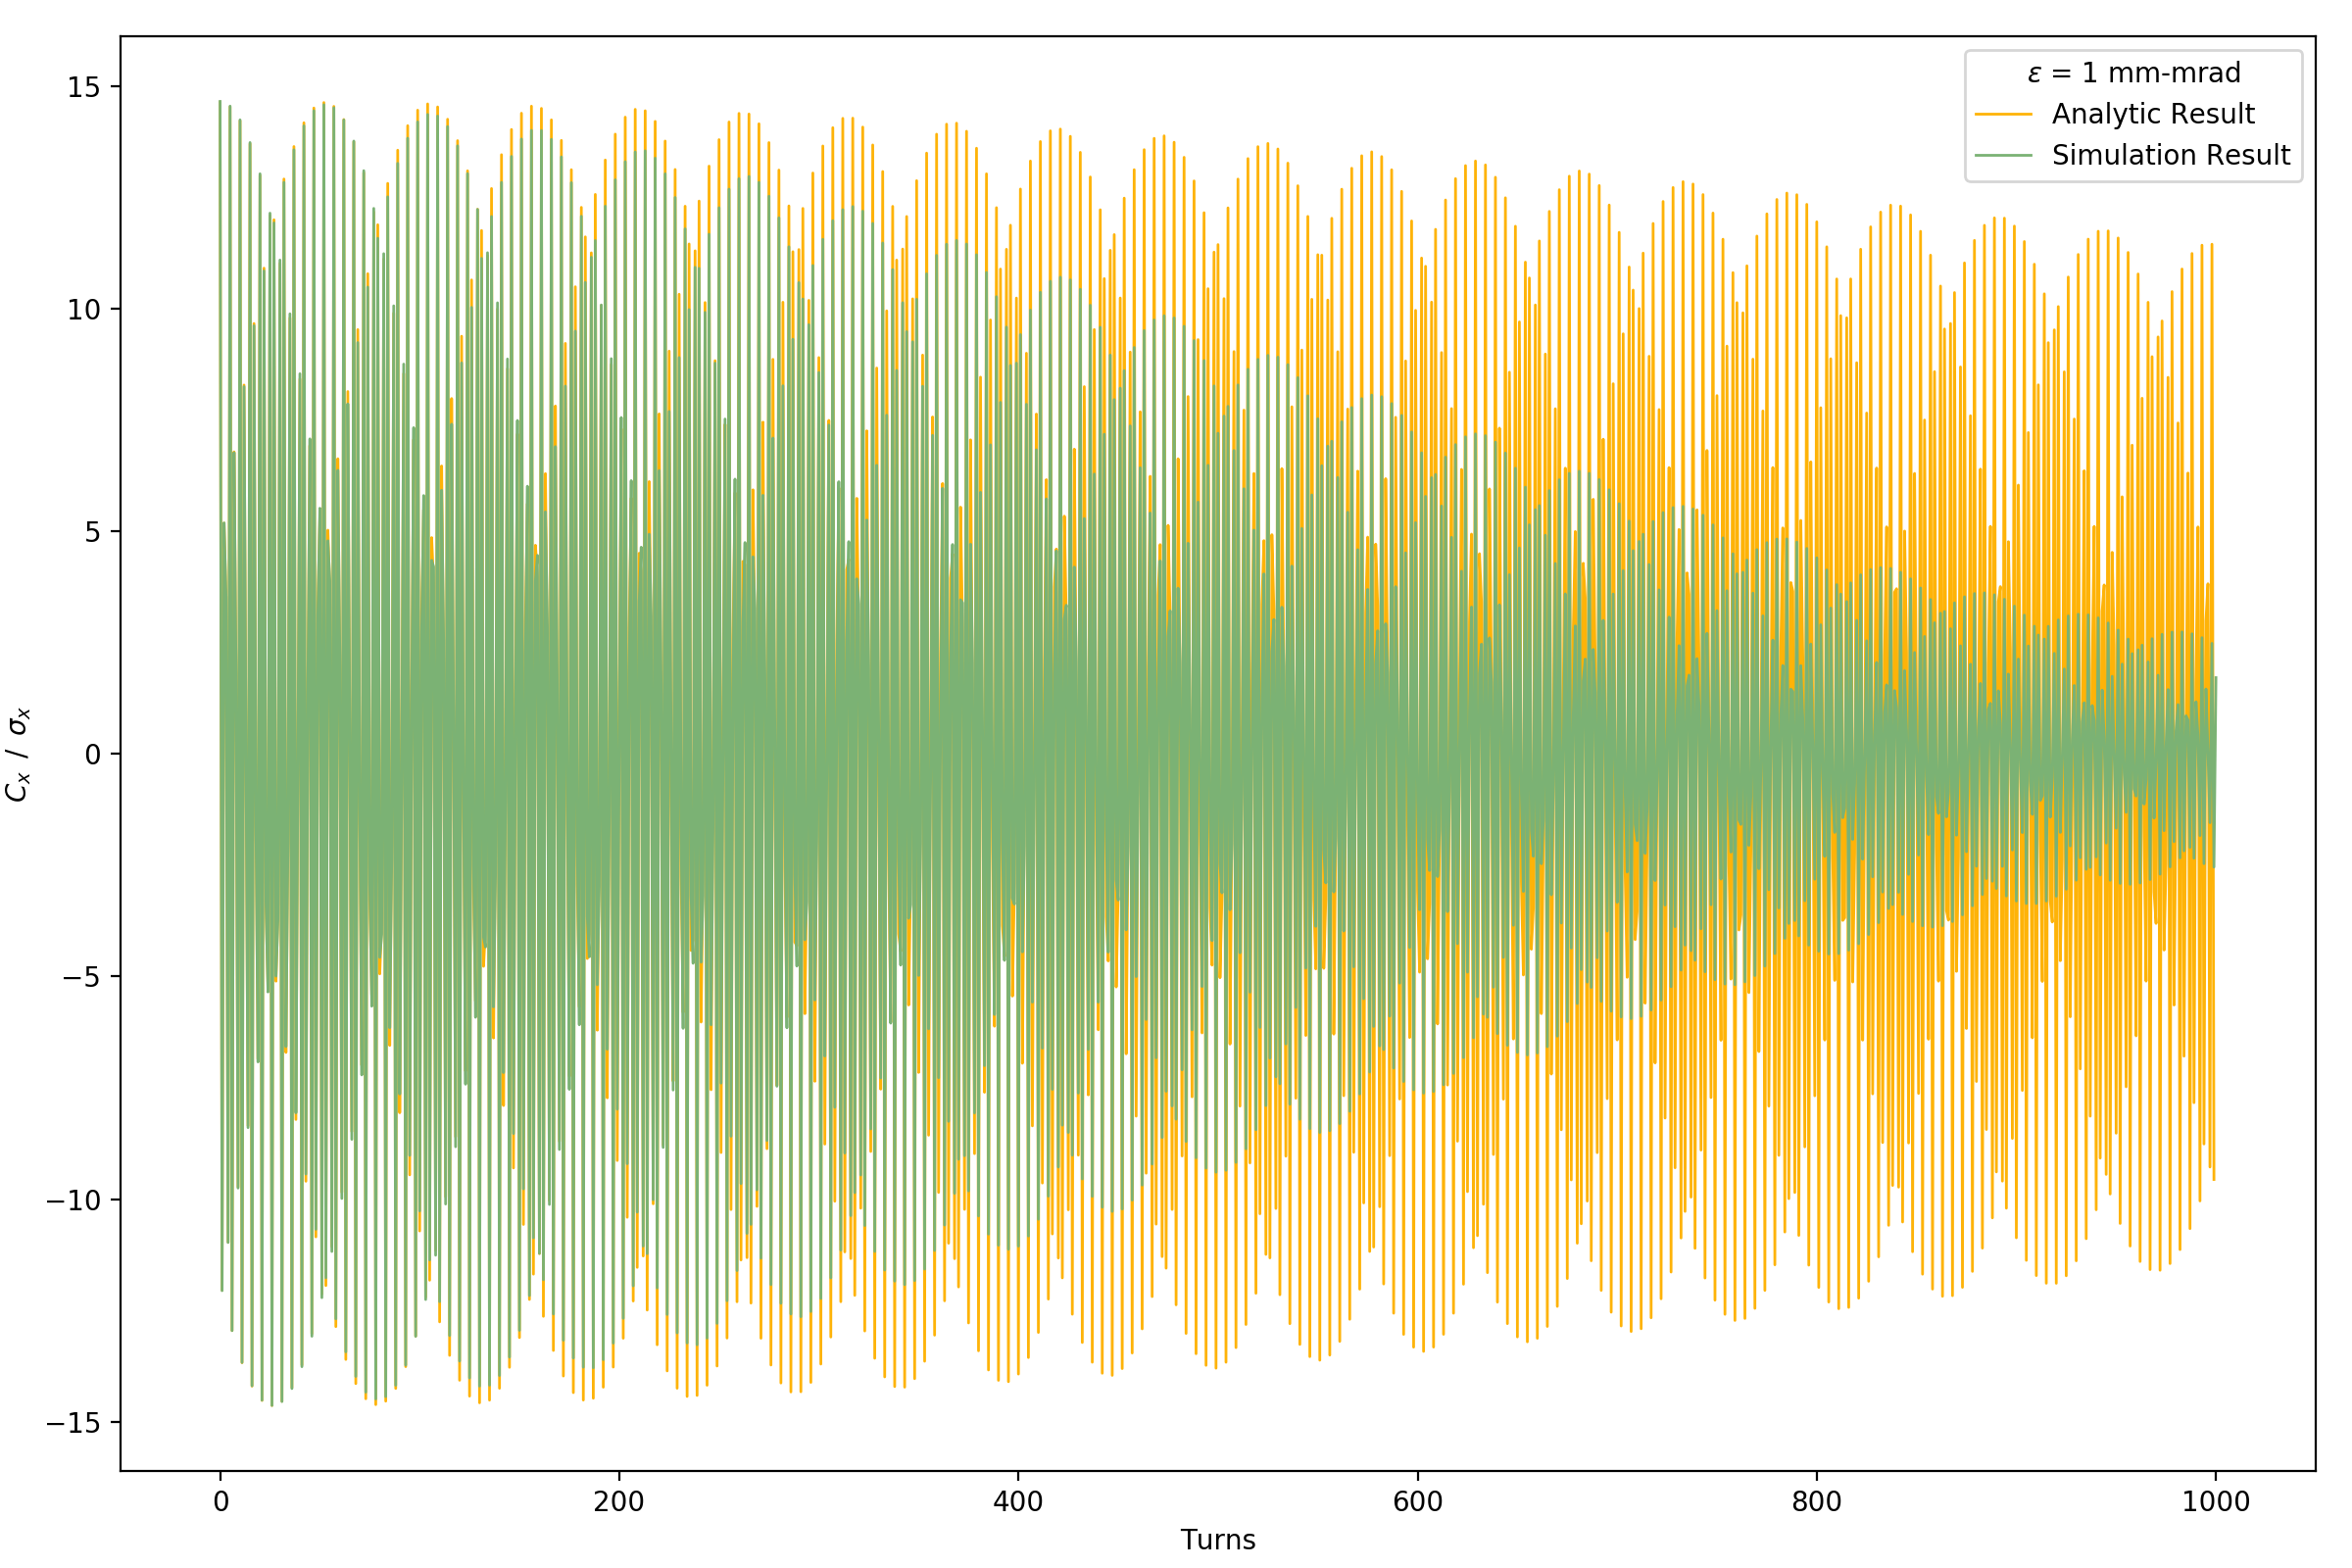

223672747738.04553


In [157]:
test, ax1 = subplots(1, 1, figsize=(12, 8))

emittance = 10e-6 / 195.695119849
rms_x = np.array([np.std(coordinates[i,:,0]) for i in range(turns // (interval * mod) + 1)])[0]
Z = 1e-3
for mn in range(1):
        if mn==0:
            mc = colors[1]
        elif mn==1:
            mc = colors[2]
        elif mn==2:
            mc = colors[6]
        elif mn==3:
            mc = colors[4]
            
        nu0, mu = 5.404, [emittance * 3 / (16 * np.pi) * np.sum(k3 * beta_x(60)**2),]
        trial_function = CentroidPosition(turns,  Z / rms_x, nu0, mu)
        trial_data = trial_function.calculate_centroids(p=20)
        ax1.plot(np.arange(turns), trial_data[:turns], 
                 linewidth=1, c=colors[1], label="Analytic Result")
        ax1.plot(np.arange(turns +1 )[::interval * mod], 
                 np.array([np.average(coordinates[i,:,0]) for i in range(turns // (interval * mod) + 1)]) / rms_x, 
                 linewidth=1, c=colors[2], label="Simulation Result")
        ax1.set_xlabel("Turns")
        ax1.set_ylabel('$C_x \, \, \, / \, \,\, \sigma_x$')
        ax1.legend(title=r"$\varepsilon$ = {} mm-mrad".format(1))

        
print(np.sum((np.array(trial_data) - np.array([np.average(coordinates[i,:-1,0]) for i in range(turns // (interval * mod))]) / rms_x)/ 
             np.array([np.average(coordinates[i,:-1,0]) for i in range(turns // (interval * mod))]) / rms_x))
test.savefig('decoherence_no_comp.pdf')
plt.tight_layout()
plt.show()

In [16]:
interp_rmsx = interp1d(np.arange(turns +1 )[::interval * mod], 
        np.array([np.std(coordinates[i,:,0]) for i in range(turns // (interval * mod) + 1)]))

<IPython.core.display.Javascript object>


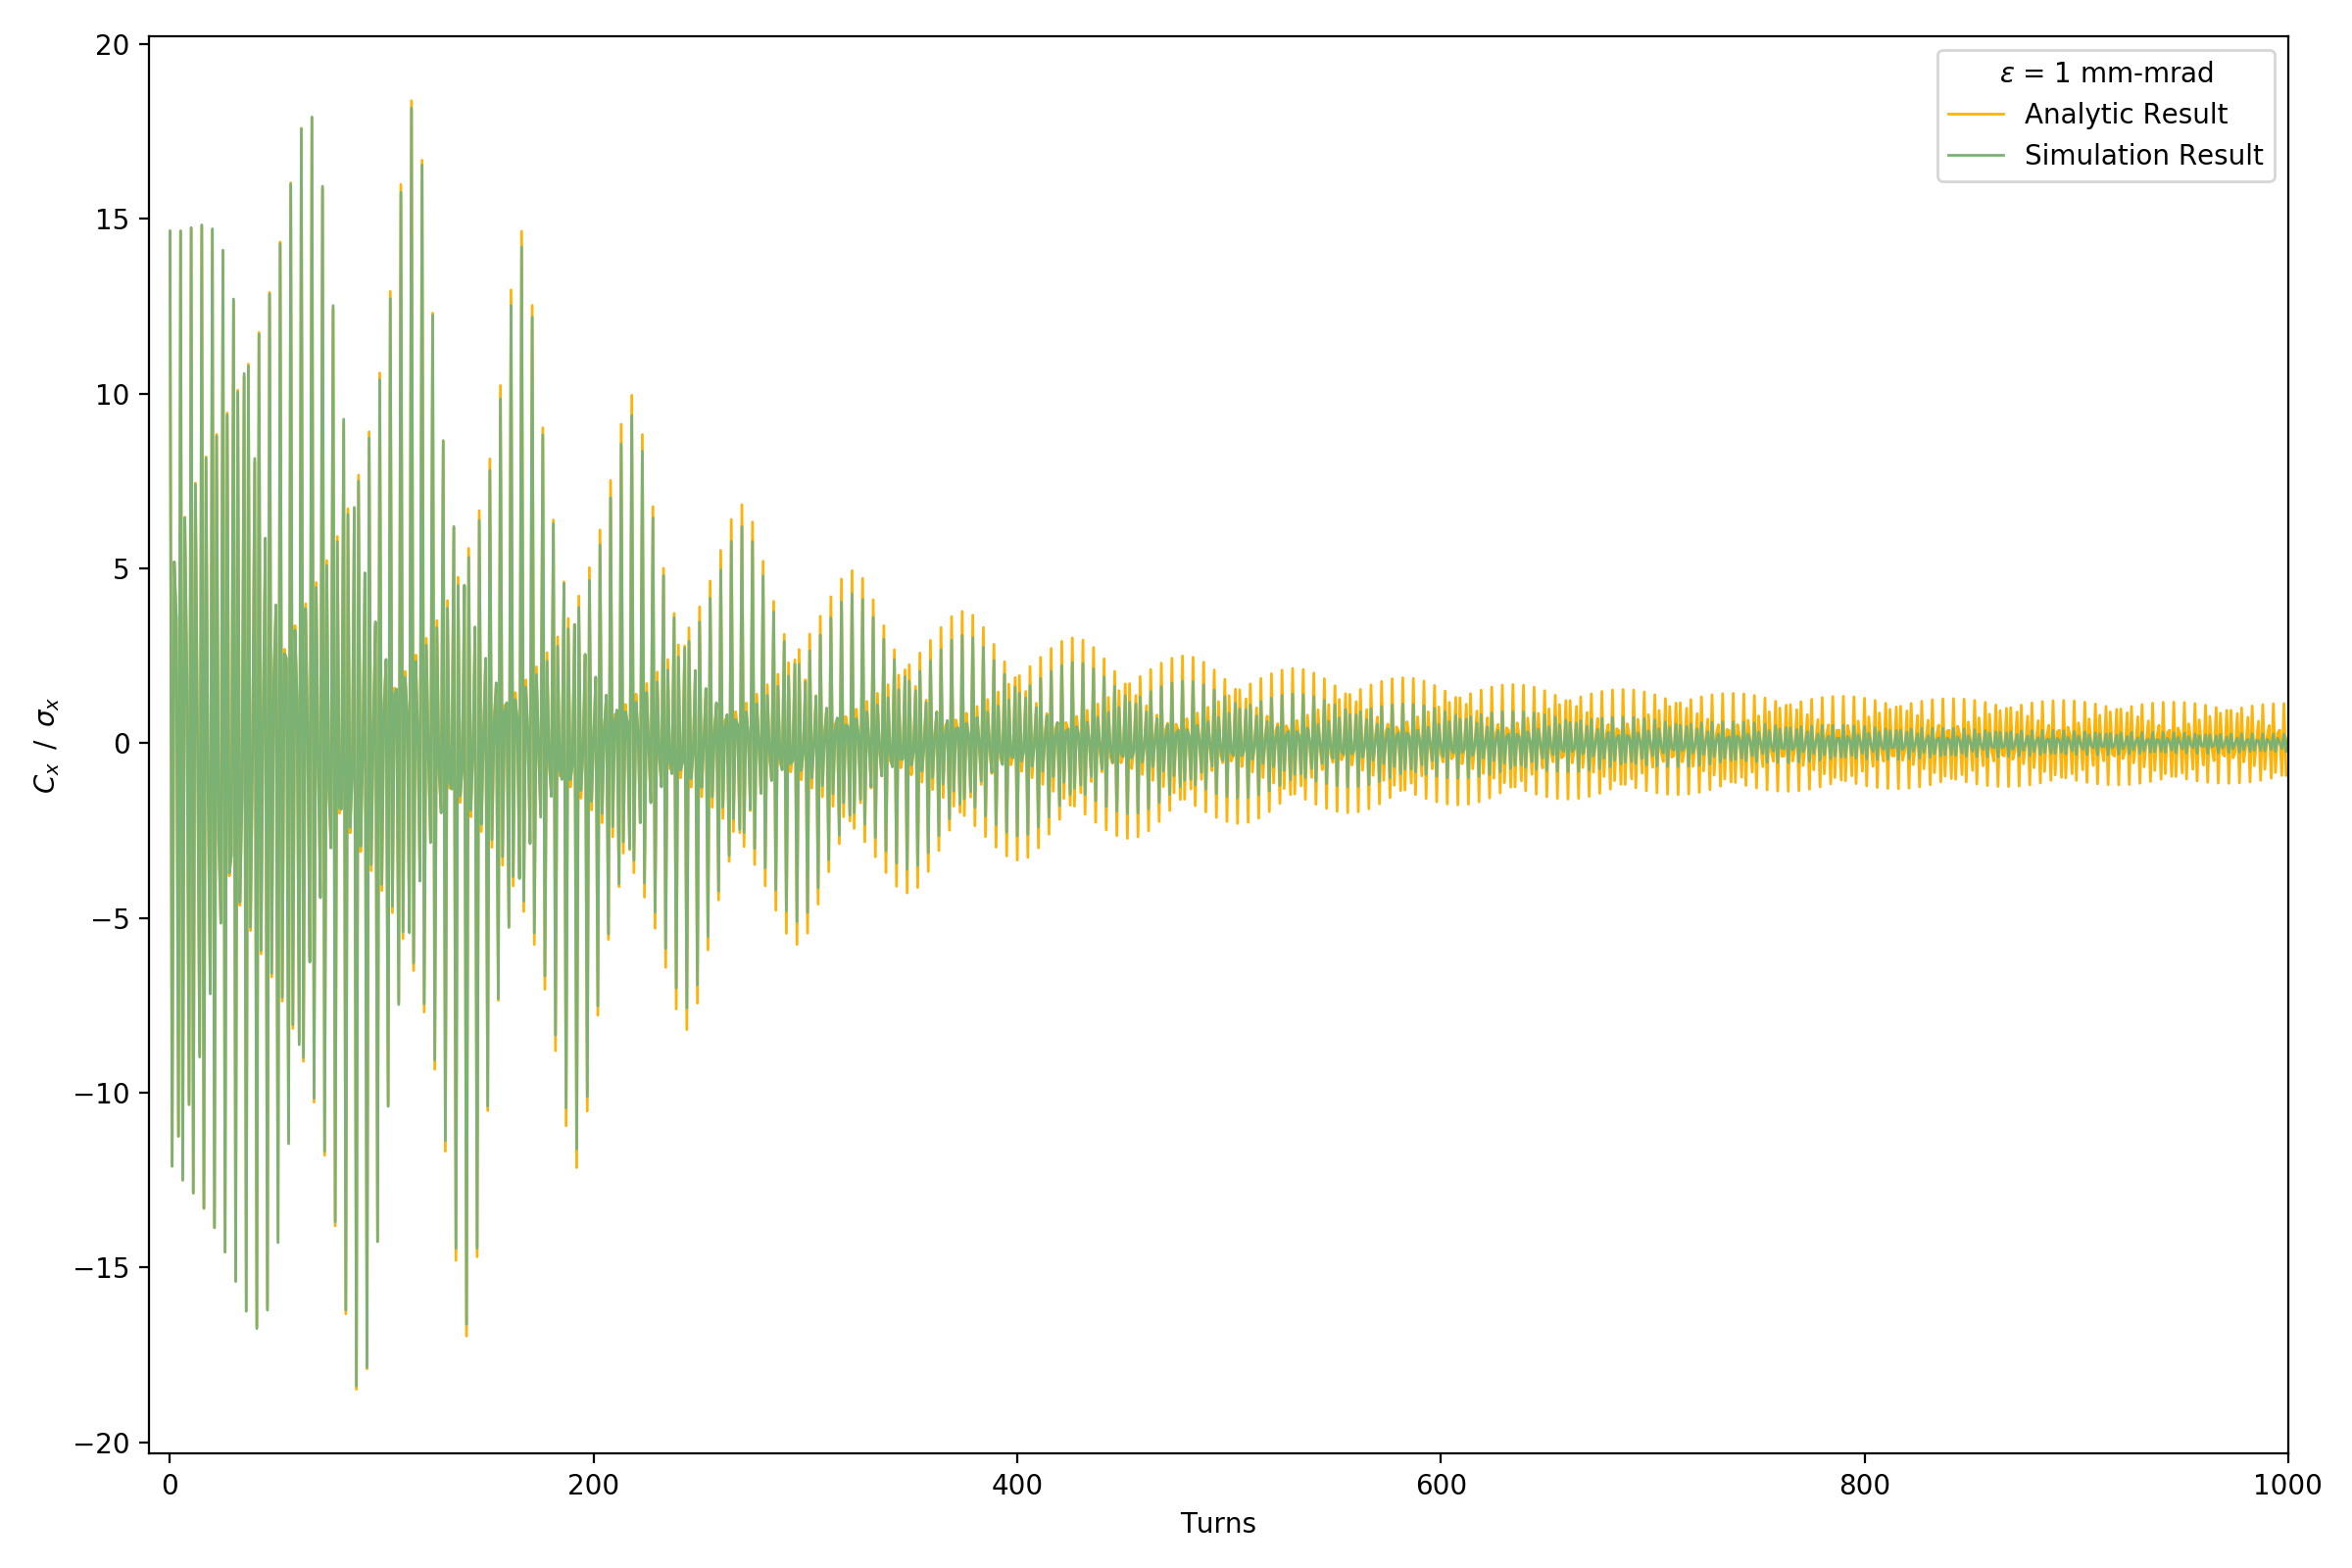

23912857842.17855


In [155]:
test2, ax1 = subplots(1, 1, figsize=(12, 8))
x0 = np.array([np.std(coordinates[i,:,0]) for i in range(turns // (interval * mod) + 1)])[0]
emittance = 10e-6 / 195.695119849
rms_x = interp_rmsx(np.arange(turns +1 ))
Z = 1e-3
for mn in range(1):
        if mn==0:
            mc = colors[1]
        elif mn==1:
            mc = colors[2]
        elif mn==2:
            mc = colors[6]
        elif mn==3:
            mc = colors[4]
            
        nu0, mu = 5.404, [emittance * 3 / (16 * np.pi) * np.sum(k3 * beta_x(60)**2),]
        trial_function = CentroidPosition(turns,  Z / rms_x, nu0, mu)
        trial_data = trial_function.calculate_centroids(p=20)
        ax1.plot(np.arange(turns), np.array(trial_data[:turns]), 
                 linewidth=1, c=colors[1], label="Analytic Result")
        ax1.plot(np.arange(turns +1 )[::interval * mod], 
                 np.array([np.average(coordinates[i,:,0]) for i in range(turns // (interval * mod) + 1)]) / rms_x[::interval * mod], 
                 linewidth=1, c=colors[2], label="Simulation Result")
        ax1.set_xlabel("Turns")
        ax1.set_ylabel('$C_x \, \, \, / \, \,\, \sigma_x$')
        ax1.legend(title=r"$\varepsilon$ = {} mm-mrad".format(1))

print(np.sum((np.array(trial_data) - np.array([np.average(coordinates[i,:-1,0]) for i in range(turns // (interval * mod))]) / rms_x[-1])/ 
     np.array([np.average(coordinates[i,:-1,0]) for i in range(turns // (interval * mod))]) / rms_x[:-1]))

ax1.set_xlim(-10, 1000)
plt.tight_layout()
# test2.savefig("decoherence_with_comp.pdf")
plt.show()

### Fitting

In [44]:
from scipy.optimize import curve_fit, differential_evolution, minimize

In [48]:
def wrap_function(*args):
    Z = 1e-3 / interp_rmsx(np.arange(turns +1 ))
    N=201
    nu0 = args[0]
    print(nu0)
#     print(args[1])
    nu0, mu = nu0, [emittance * 3 / (16 * np.pi) * np.sum(k3 * beta_x(60)**2),]
    fit_function = CentroidPosition(N, Z, nu0, mu)

    return np.sum((fit_function.calculate_centroids() - np.array([np.average(coordinates[i,:,0]) for i in range(200 + 1)]) /  rms_x[:201])**2)

In [49]:
r1, r2 = minimize(wrap_function, x0=[5.3,], method='Nelder-Mead')

[5.3]
[5.565]
[5.83]
[5.4325]
[5.4325]
[5.6975]
[5.83]
[5.83]
[5.63125]
[5.565]
[5.664375]
[5.664375]
[5.598125]
[5.565]
[5.565]
[5.6146875]
[5.6146875]
[5.5815625]
[5.58984375]
[5.60640625]
[5.59398438]
[5.60226563]
[5.59605469]
[5.59398438]
[5.59708984]
[5.59501953]
[5.59657227]
[5.59708984]
[5.59631348]
[5.59605469]
[5.59644287]
[5.59657227]
[5.59637817]
[5.59631348]
[5.59641052]
[5.59644287]
[5.59639435]
[5.5964267]
[5.59640244]
[5.59641861]
[5.59640648]
[5.59640244]
[5.5964085]
[5.59641052]
[5.59640749]
[5.59640648]
[5.596408]
[5.5964085]
[5.59640774]


ValueError: too many values to unpack

In [41]:
initialize = [5.3,]

In [42]:
popt, pcov = curve_fit(wrap_function,
                       np.arange(200 +1 ), 
                       np.array([np.average(coordinates[i,:,0]) for i in range(200 + 1)]) /  rms_x[:201],
                       initialize,
                       method='dogbox')

print popt, pcov

5.3
5.300000078976154
5.3000274166856025
5.300027495662166
5.300055824250357
5.300055903227343
5.300085116094672
5.300085195072095
5.300115165994887
5.3001152449727575
5.300145830153122
5.300145909131449
5.300176950264693
5.300177029243485
5.300208357464345
5.3002084364436035
5.30023987693346
5.300239955913189
5.300271332891193
5.300271411871391
5.300302553601697
5.30030263258236
5.300333376068131
5.300333455049253
5.300363650090458
5.300363729072031
5.300393241491716
5.30039332047373
5.300422034353844
5.300422113336287
5.3004499322499985
5.300450011232857
5.300476858542224
5.300476937525484
5.300502755835888
5.300502834819534
5.300527584816485
5.3005276638005006
5.300551322605369
5.300551401589738
5.300573960831549
5.300574039816256
5.300595503581858
5.300595582566887
5.300615965334197
5.30061604431953
5.30063536898886
5.300635447974482
5.300653744061414
5.30065382304731
5.300671125049301
5.3006712040354556
5.300687550027218
5.300687629013618
5.30070305944293
5.300703138429561
5.30071

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

<IPython.core.display.Javascript object>


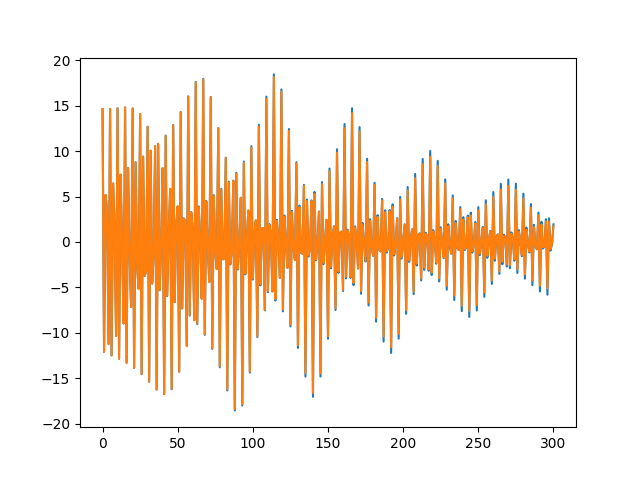

In [50]:
plt.figure()
Z = 1e-3 / interp_rmsx(np.arange(turns +1 ))
N=301
nu0 = 5.3
#     print(args[1])
nu0, mu = 5.59640774, [emittance * 3 / (16 * np.pi) * np.sum(k3 * beta_x(60)**2),]
fit_function = CentroidPosition(N, Z, nu0, mu)

plt.plot(np.arange(300 +1 )[::interval * mod], 
                       fit_function.calculate_centroids()[::interval * mod])

plt.plot(np.arange(300 +1 )[::interval * mod], 
                       np.array([np.average(coordinates[i,:,0]) for i in range(300 // (interval * mod) + 1)]) / rms_x[:301:interval * mod])

plt.show()

## Single Particle Analysis


<IPython.core.display.Javascript object>


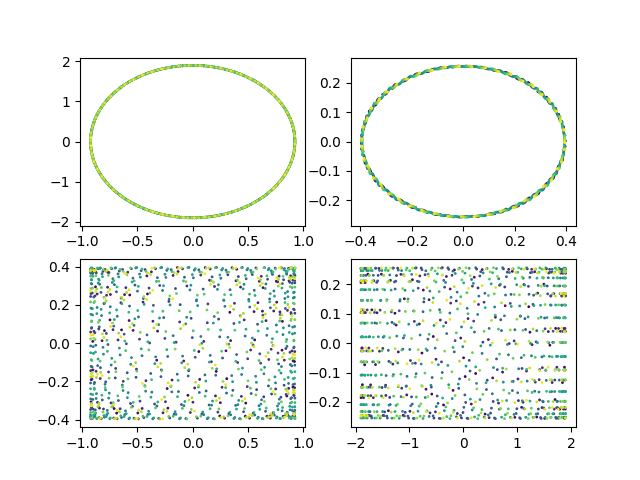

In [93]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# 16
key = '16'
#particles= [1501,8,19, 25, 30, 86, 6, 8858, 7851]
particle = 15

ax1.scatter(coordinates[:,particle,0] * 1e3,
           coordinates[:,particle,1] * 1e3, s=1, c=range(coordinates[:,particle,0].shape[0]))


ax2.scatter(coordinates[:,particle,2] * 1e3,
           coordinates[:,particle,3] * 1e3, s=1, c=range(coordinates[:,particle,0].shape[0]))


ax3.scatter(coordinates[:,particle,0] * 1e3,
           coordinates[:,particle,2] * 1e3, s=1, c=range(coordinates[:,particle,0].shape[0]))


ax4.scatter(coordinates[:,particle,1] * 1e3,
           coordinates[:,particle,3] * 1e3, s=1, c=range(coordinates[:,particle,0].shape[0]))



plt.show()

### FFT Tunes

In [96]:
turn_min = 0
turn_max = 1000

freq = np.fft.rfftfreq(turn_max - turn_min, interval * mod) 
nux = np.array([np.fft.rfft(coordinates[:,i,0]) for i in range(coordinates.shape[1])])
nuy = np.array([np.fft.rfft(coordinates[:,i,1]) for i in range(coordinates.shape[1])])

<IPython.core.display.Javascript object>


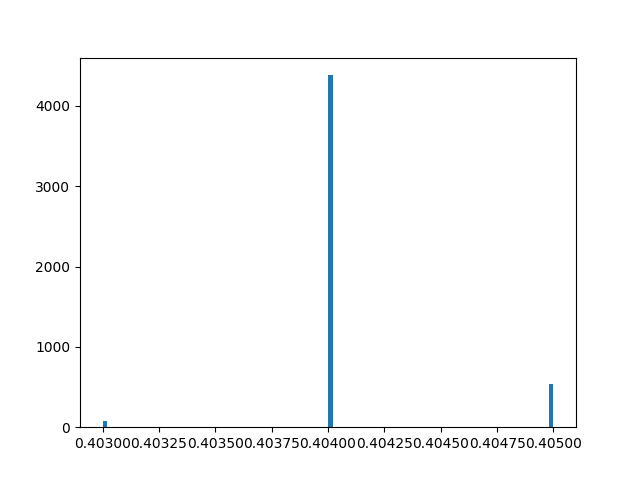

In [132]:
plt.figure()

nux_distr = np.argmax(np.abs(nuy), axis=1)

plt.hist(freq[nux_distr], bins=100)

plt.show()

In [110]:
np.argmax(nux, axis=1).shape

(5000,)

<IPython.core.display.Javascript object>


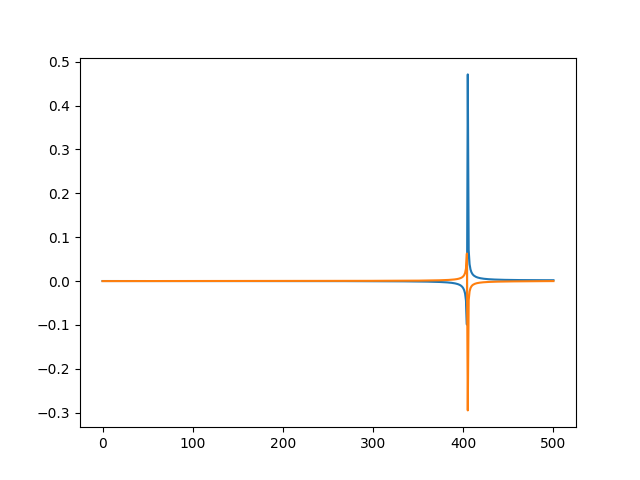

In [104]:
plt.figure()


plt.plot(np.real(nux[0, :]))
plt.plot(np.imag(nux[0, :]))

plt.show()